This notebook contains the code for recreating the plots and the statistics for analysis of missense mutations in the ligand-binding region of NOTCH1 in normal skin.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

In [2]:
from darwinian_shift import DarwinianShift
from darwinian_shift import CDFMonteCarloTest, BinomTest
from darwinian_shift import FoldXLookup, SequenceDistanceLookup, StructureDistanceLookup
from darwinian_shift import MutationExclusionLookup, ORLookup
from darwinian_shift import hide_top_and_right_axes
from darwinian_shift import plot_scatter_two_scores

/Users/mh28/miniconda3/envs/dsenv3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mh28/miniconda3/envs/dsenv3/lib/python3.8/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


# Setup

In [3]:
# Define the region to test
notch1_section_definition_egf11_12 = {
    'transcript_id': 'ENST00000277541', 'pdb_id': '2vj3', 'pdb_chain': 'A', 
    'start': 412, 'end': 488, # Restrict to the residues in EGF11-12
    'interface_residues': [413, 415, 418, 420, 421, 422, 423, 424, 425, 
                         435, 436, 444, 447, 448, 450, 451, 452, 454, 
                         466, 467, 468, 469, 470, 471, 475, 477, 478, 
                         479, 480],   # defined in Luca et al 2017
    'ca_binding_residues': [412, 413, 415, 431, 432, 435, 452, 453, 455, 469, 470]  # Defined by MetalPDB
}

In [4]:
d_skin = DarwinianShift(
    data = pd.read_excel('248092_3_supp_6645104_q35h43.xlsx', sheet_name='Table S4', skiprows=4),
    source_genome='GRCh37',
    spectra='skin_trinuc_spectrum.txt',
    included_mutation_types='missense'
)

In [5]:
# Directories
sifts_directory="SIFTS_files"
pdb_directory = "PDB_files"

# Colours
unobserved_colour = '#BBBBBB'  
observed_colour = '#EE7733'
foldx_expected_colour = '#EE6677'
foldx_observed_colour = '#CC3311'
interface_expected_colour = '#88CCEE'
interface_observed_colour = '#0077BB'
calcium_expected_colour = '#8DE0D7'
calcium_observed_colour = '#009988'

# Define the metrics

## Individual metrics

In [6]:
# Define the FoldX lookup
fold = FoldXLookup(foldx_results_directory="FoldX_results",
                   sifts_directory=sifts_directory,
                   foldx_file_name_start="PS_f*", download_sifts=True)

In [7]:
# Define a lookup object which determines whether mutations are on the NOTCH1-ligand interface. 
interface_lookup = SequenceDistanceLookup(
    boolean=True,   # Just a boolean on/off interface. 
    target_key='interface_residues',   # Use this entry in the section_definition dict to define the target residues
    position_type='residue',   # Use the residue number (as opposed to cdspos or chromosomal position)
    name='On interface'  # Label to appear on plot axes
)

In [8]:
ca_lookup = SequenceDistanceLookup(
    boolean=True,   # Just a boolean binding/not binding. 
    target_key='ca_binding_residues',   # Use this entry in the section_definition dict to define the target residues
    position_type='residue',   # Use the residue number (as opposed to cdspos or chromosomal position)
    name='Calcium binding'  # Label to appear on plot axes
)

## Conditional tests 

In [9]:
# First define a lookup that is 1 if the mutation is on the interface and or calcium binding
interface_or_ca_lookup = ORLookup(
    lookups=[interface_lookup, ca_lookup],  
    thresholds=[0.5, 0.5],  # Set thresholds at 0.5
    directions=[1, 1],  # Want to exclude mutations which score 1 for interface or calcium binding.
)


# Define the combined lookup.
excllook_foldx = MutationExclusionLookup(
    lookup=fold,   # Use the calcium binding lookup for the test
    exclusion_lookup=interface_or_ca_lookup,
    exclusion_threshold=0.5,  #  Scores from the exclusion are either 0, or 1, so can put threshold anywhere in between.
    exclusion_direction=1,   # Exclude mutations with a score above the exclusion_threhold from the exclusion_lookup.
    name=fold.name
)

In [10]:
# Define a lookup to test the interface while excluding destabilising mutations. 
excllook_interface_foldx_only = MutationExclusionLookup(
    lookup=interface_lookup,   # Use the interface lookup for the test
    exclusion_lookup=fold,   
    exclusion_threshold=2,  #  Exclude mutations with ∆∆G higher than 2kcal/mol.
    exclusion_direction=1,   # Exclude mutations with a score above the exclusion_threhold from the exclusion_lookup.
    name=interface_lookup.name
)

In [11]:
# First define a lookup that is 1 if the mutation is destabilising or calcium binding
destabilising_or_ca_lookup = ORLookup(
    lookups=[fold, ca_lookup],  
    thresholds=[2, 0.5],  # Use 2kcal/mol as the ∆∆G threshold. Ca score is 0 or 1, so set threshold at 0.5
    directions=[1, 1],  # Want to exclude mutations which score 1 for calcium binding or > 2 for ∆G.
)


# Define the combined lookup.
excllook_interface = MutationExclusionLookup(
    lookup=interface_lookup,   # Use the inteface lookup for the test
    exclusion_lookup=destabilising_or_ca_lookup,   
    exclusion_threshold=0.5,  #  Scores from the exclusion are either 0, or 1, so can put threshold anywhere in between.
    exclusion_direction=1,   # Exclude mutations with a score above the exclusion_threhold from the exclusion_lookup.
    name=interface_lookup.name
)

In [12]:
# First define a lookup that is 1 if the mutation is destabilising or on the interface and 0 otherwise.
destabilising_or_interface_lookup = ORLookup(
    lookups=[fold, interface_lookup],  # Use the FoldX and the interface lookups.  
    thresholds=[2, 0.5],  # Again pick a threshold of 2kcal/mol for the FoldX result, interface results are either 0 or 1 so set threshold at 0.5. 
    directions=[1, 1],  # Want to exclude mutations with scores greater than the thresholds, so directions are both 1.
)


# Define the combined lookup.
excllook_ca = MutationExclusionLookup(
    lookup=ca_lookup,   # Use the calcium binding lookup for the test
    exclusion_lookup=destabilising_or_interface_lookup,   
    exclusion_threshold=0.5,  #  Scores from the exclusion are either 0, or 1, so can put threshold anywhere in between.
    exclusion_direction=1,   # Exclude mutations with a score above the exclusion_threhold from the exclusion_lookup.
    name=ca_lookup.name
)

# Tests

## FoldX

### FoldX - no exclusions

In [13]:
# Run an analysis of FoldX scores using the CDF Monte Carlo Test
s = d_skin.run_section(notch1_section_definition_egf11_12, lookup=fold, 
                     statistics=CDFMonteCarloTest(num_draws=100000))

In [14]:
s.get_results_dictionary()

{'gene': 'NOTCH1',
 'transcript_id': 'ENST00000277541',
 'chrom': '9',
 'section_id': '2vj3:A',
 'num_mutations': 905,
 'observed_median': 1.96125,
 'observed_mean': 3.567908390607735,
 'expected_median_glob_k3': 0.72928,
 'median_shift_glob_k3': 1.23197,
 'expected_mean_glob_k3': 1.65968495845889,
 'mean_shift_glob_k3': 1.9082234321488452,
 'CDF_MC_glob_k3_num_smaller_or_equal': 100001,
 'CDF_MC_glob_k3_num_larger_or_equal': 1,
 'CDF_MC_glob_k3_pvalue': 1.999980000199998e-05,
 'CDF_MC_glob_k3_cdf_mean': 0.6477728219584489}

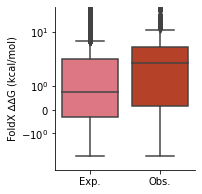

In [15]:
s.plot_boxplot(figsize=(2.5, 3), plot_scale='symlog',
                    colours=[foldx_observed_colour, foldx_expected_colour])
hide_top_and_right_axes()
plt.xticks(plt.gca().get_xticks(), ['Exp.', 'Obs.']);

### Excluding CA binding and interface

In [16]:
# Run again, this time only on mutations which are not on the ligand-binding interface or calcium-binding residues.
s = d_skin.run_section(notch1_section_definition_egf11_12, lookup=excllook_foldx, 
                     statistics=CDFMonteCarloTest(num_draws=100000))

In [17]:
s.get_results_dictionary()

{'gene': 'NOTCH1',
 'transcript_id': 'ENST00000277541',
 'chrom': '9',
 'section_id': '2vj3:A',
 'num_mutations': 452,
 'observed_median': 4.31605,
 'observed_mean': 5.585752362831858,
 'expected_median_glob_k3': 0.85534,
 'median_shift_glob_k3': 3.4607099999999997,
 'expected_mean_glob_k3': 2.2953249579660078,
 'mean_shift_glob_k3': 3.2904274048658504,
 'CDF_MC_glob_k3_num_smaller_or_equal': 100001,
 'CDF_MC_glob_k3_num_larger_or_equal': 1,
 'CDF_MC_glob_k3_pvalue': 1.999980000199998e-05,
 'CDF_MC_glob_k3_cdf_mean': 0.7466097118473951}

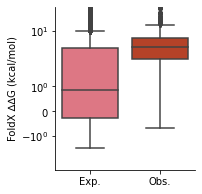

In [18]:
s.plot_boxplot(figsize=(2.5, 3), plot_scale='symlog',
                    colours=[foldx_observed_colour, foldx_expected_colour])
hide_top_and_right_axes()
plt.xticks(plt.gca().get_xticks(), ['Exp.', 'Obs.']);

## Interface

### Interface - no exclusions

In [19]:
# Test whether there is enrichment of mutations on the ligand-binding interface
# Because the mutations are scored with only 1 and 0 (on/off the interface), we can use a binomial test
s = d_skin.run_section(notch1_section_definition_egf11_12, lookup=interface_lookup, 
                    statistics=BinomTest())

In [20]:
s.get_results_dictionary()

{'gene': 'NOTCH1',
 'transcript_id': 'ENST00000277541',
 'chrom': '9',
 'section_id': '2vj3:A',
 'num_mutations': 905,
 'observed_median': 0.0,
 'observed_mean': 0.3911602209944751,
 'expected_median_glob_k3': 0.0,
 'median_shift_glob_k3': 0.0,
 'expected_mean_glob_k3': 0.3658104078440008,
 'mean_shift_glob_k3': 0.0253498131504743,
 'binom_glob_k3_pvalue': 0.12040433821002669,
 'binom_glob_k3_expected_proportion': 0.3658104078440009,
 'binom_glob_k3_observed_proportion': 0.3911602209944751,
 'binom_glob_k3_expected_count': 331.05841909882076,
 'binom_glob_k3_observed_count': 354,
 'binom_glob_k3_threshold': 0.5,
 'binom_glob_k3_expected_CI_high': 360.0,
 'binom_glob_k3_expected_CI_low': 302.0,
 'binom_glob_k3_observed_CI_low': 325.0,
 'binom_glob_k3_observed_CI_high': 383.0}

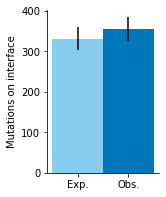

In [21]:
s.plot_binomial(figsize=(2, 3), show_legend=False, colours=[interface_observed_colour, interface_expected_colour])
plt.title("")
plt.ylabel('Mutations on interface')
hide_top_and_right_axes(plt.gca())

## CA binding

### CA - no exclusions

In [22]:
# Test for enrichment of calcium-binding mutations. 
# 1/0 scores so can use the binomial test
s = d_skin.run_section(notch1_section_definition_egf11_12, lookup=ca_lookup, 
                    statistics=BinomTest())

/Users/mh28/miniconda3/envs/dsenv3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:69: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


In [23]:
s.get_results_dictionary()

{'gene': 'NOTCH1',
 'transcript_id': 'ENST00000277541',
 'chrom': '9',
 'section_id': '2vj3:A',
 'num_mutations': 905,
 'observed_median': 0.0,
 'observed_mean': 0.17679558011049723,
 'expected_median_glob_k3': 0.0,
 'median_shift_glob_k3': 0.0,
 'expected_mean_glob_k3': 0.18912403837279465,
 'mean_shift_glob_k3': -0.01232845826229742,
 'binom_glob_k3_pvalue': 0.3726709229900576,
 'binom_glob_k3_expected_proportion': 0.18912403837279465,
 'binom_glob_k3_observed_proportion': 0.17679558011049723,
 'binom_glob_k3_expected_count': 171.15725472737915,
 'binom_glob_k3_observed_count': 160,
 'binom_glob_k3_threshold': 0.5,
 'binom_glob_k3_expected_CI_high': 194.0,
 'binom_glob_k3_expected_CI_low': 148.0,
 'binom_glob_k3_observed_CI_low': 138.0,
 'binom_glob_k3_observed_CI_high': 183.0}

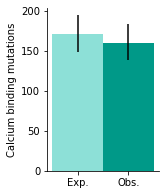

In [24]:
s.plot_binomial(figsize=(2, 3), show_legend=False, # binom_test=d_sms.statistics[-1],
                                      colours=[calcium_observed_colour, calcium_expected_colour])
plt.title("")
plt.ylabel('Calcium binding mutations')
hide_top_and_right_axes(plt.gca())

# FoldX threshold checking

In [25]:
 # Try different thresholds for excluding destabilising mutations to confirm the conclusions are not altered
thresholds = [1, 1.5, 2, 2.5, 3] 

## Interface

In [26]:
excllookups = []
for t in thresholds:
    # First define a lookup that is 1 if the mutation is destabilising or calcium binding
    l1 = ORLookup(
        lookups=[fold, ca_lookup],  
        thresholds=[t, 0.5],  
        directions=[1, 1],  
    )


    # Define the combined lookup.
    l2 = MutationExclusionLookup(
        lookup=interface_lookup,   
        exclusion_lookup=l1,   
        exclusion_threshold=0.5,  
        exclusion_direction=1,   
        name=interface_lookup.name
    )

    excllookups.append(l2)

In [27]:
s_interfaces_with_thresholds = [
    d_skin.run_section(notch1_section_definition_egf11_12, lookup=ll, statistics=BinomTest()) for ll in excllookups
]
results = [s.get_results_dictionary() for s in s_interfaces_with_thresholds]

In [28]:
observed_counts = np.array([r['binom_glob_k3_observed_count'] for r in results])
expected_counts = np.array([r['binom_glob_k3_expected_count'] for r in results])
observed_ci_low = np.array([r['binom_glob_k3_observed_CI_low'] for r in results])
observed_ci_high = np.array([r['binom_glob_k3_observed_CI_high'] for r in results])
expected_ci_low = np.array([r['binom_glob_k3_expected_CI_low'] for r in results])
expected_ci_high = np.array([r['binom_glob_k3_expected_CI_high'] for r in results])
pvalues_binom = [r['binom_glob_k3_pvalue'] for r in results]

In [29]:
pvalues_binom

[6.010228146076045e-30,
 6.665883812400356e-31,
 2.4240652229094823e-25,
 1.031427980288003e-18,
 6.5610773793757904e-21]

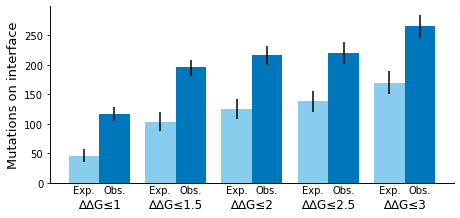

In [30]:
fig, ax = plt.subplots(figsize=(7, 3.5))
width = 0.4
x_pos = np.arange(5)

plt.bar(x_pos, expected_counts, yerr=[expected_counts-expected_ci_low, expected_ci_high-expected_counts],
        width=width, color=interface_expected_colour)
plt.bar(x_pos+width, observed_counts, yerr=[observed_counts-observed_ci_low, observed_ci_high-observed_counts],
        width=width, color=interface_observed_colour)
plt.xticks(sorted(list(x_pos) + list(x_pos+width)), ['Exp.', 'Obs.']*5, fontsize=10)
ax.tick_params(axis='x', direction='out', pad=2, length=0)
fig.subplots_adjust(bottom=0.25)
ax2 = plt.gca().twiny()
ax2.patch.set_visible(False)
hide_top_and_right_axes(ax2)
hide_top_and_right_axes(ax)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.set_xticks(x_pos+width/2)
ax2.set_xticklabels(['∆∆G≤{}'.format(t) for t in thresholds], fontsize=12, ha='center')
ax2.set_xlim(ax.get_xlim())
ax2.tick_params(axis='x', length=0, pad=15)
ax.set_ylabel('Mutations on interface', fontsize=13)
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.9)

In [31]:
for r, t in zip(results, thresholds):
    r['foldx_threshold'] = t

In [32]:
pd.DataFrame(results)

,gene,transcript_id,chrom,section_id,num_mutations,observed_median,observed_mean,expected_median_glob_k3,median_shift_glob_k3,expected_mean_glob_k3,...,binom_glob_k3_expected_proportion,binom_glob_k3_observed_proportion,binom_glob_k3_expected_count,binom_glob_k3_observed_count,binom_glob_k3_threshold,binom_glob_k3_expected_CI_high,binom_glob_k3_expected_CI_low,binom_glob_k3_observed_CI_low,binom_glob_k3_observed_CI_high,foldx_threshold
0,NOTCH1,ENST00000277541,9,2vj3:A,169,1.0,0.692308,0.0,1.0,0.271367,...,0.271367,0.692308,45.860972,117,0.5,57.0,35.0,105.0,128.0,1.0
1,NOTCH1,ENST00000277541,9,2vj3:A,260,1.0,0.753846,0.0,1.0,0.399694,...,0.399694,0.753846,103.920493,196,0.5,120.0,88.0,182.0,209.0,1.5
2,NOTCH1,ENST00000277541,9,2vj3:A,315,1.0,0.685714,0.0,1.0,0.394800,...,0.394800,0.685714,124.361890,216,0.5,142.0,108.0,199.0,232.0,2.0
3,NOTCH1,ENST00000277541,9,2vj3:A,360,1.0,0.613889,0.0,1.0,0.383162,...,0.383162,0.613889,137.938205,221,0.5,156.0,120.0,202.0,239.0,2.5
4,NOTCH1,ENST00000277541,9,2vj3:A,425,1.0,0.625882,0.0,1.0,0.399197,...,0.399197,0.625882,169.658927,266,0.5,190.0,150.0,246.0,285.0,3.0


## CA binding

In [33]:
excllookups = []
for t in thresholds:
    # First define a lookup that is 1 if the mutation is destabilising or calcium binding
    l1 = ORLookup(
        lookups=[fold, interface_lookup],  
        thresholds=[t, 0.5],  
        directions=[1, 1],  
    )


    # Define the combined lookup.
    l2 = MutationExclusionLookup(
        lookup=ca_lookup,   
        exclusion_lookup=l1,   
        exclusion_threshold=0.5,  
        exclusion_direction=1,   
        name=ca_lookup.name
    )
    
    excllookups.append(l2)

In [34]:
s_with_thresholds = [
    d_skin.run_section(notch1_section_definition_egf11_12, lookup=ll, statistics=BinomTest()) for ll in excllookups
]
results = [s.get_results_dictionary() for s in s_with_thresholds]
for r, t in zip(results, thresholds):
    r['foldx_threshold'] = t

In [35]:
observed_counts = np.array([r['binom_glob_k3_observed_count'] for r in results])
expected_counts = np.array([r['binom_glob_k3_expected_count'] for r in results])
observed_ci_low = np.array([r['binom_glob_k3_observed_CI_low'] for r in results])
observed_ci_high = np.array([r['binom_glob_k3_observed_CI_high'] for r in results])
expected_ci_low = np.array([r['binom_glob_k3_expected_CI_low'] for r in results])
expected_ci_high = np.array([r['binom_glob_k3_expected_CI_high'] for r in results])
pvalues_binom = [r['binom_glob_k3_pvalue'] for r in results]

In [36]:
pvalues_binom

[5.917391361125157e-31,
 1.962056703423747e-29,
 2.2196487193789853e-22,
 6.565456051070581e-17,
 1.796501717065694e-15]

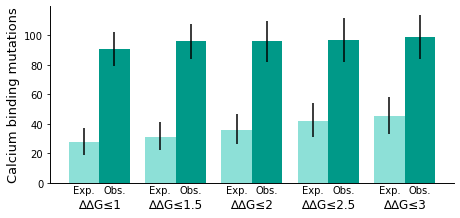

In [37]:
fig, ax = plt.subplots(figsize=(7, 3.5))
width = 0.4
x_pos = np.arange(5)

plt.bar(x_pos, expected_counts, yerr=[expected_counts-expected_ci_low, expected_ci_high-expected_counts],
        width=width, color=calcium_expected_colour)
plt.bar(x_pos+width, observed_counts, yerr=[observed_counts-observed_ci_low, observed_ci_high-observed_counts],
        width=width, color=calcium_observed_colour)
plt.xticks(sorted(list(x_pos) + list(x_pos+width)), ['Exp.', 'Obs.']*5, fontsize=10) 
ax.tick_params(axis='x', direction='out', pad=2, length=0)
fig.subplots_adjust(bottom=0.25)
ax2 = plt.gca().twiny()
ax2.patch.set_visible(False)
hide_top_and_right_axes(ax2)
hide_top_and_right_axes(ax)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.set_xticks(x_pos+width/2)
ax2.set_xticklabels(['∆∆G≤{}'.format(t) for t in thresholds], fontsize=12, ha='center')
ax2.set_xlim(ax.get_xlim())
ax2.tick_params(axis='x', length=0, pad=15)
ax.set_ylabel('Calcium binding mutations', fontsize=13)
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.9)

In [38]:
pd.DataFrame(results)

,gene,transcript_id,chrom,section_id,num_mutations,observed_median,observed_mean,expected_median_glob_k3,median_shift_glob_k3,expected_mean_glob_k3,...,binom_glob_k3_expected_proportion,binom_glob_k3_observed_proportion,binom_glob_k3_expected_count,binom_glob_k3_observed_count,binom_glob_k3_threshold,binom_glob_k3_expected_CI_high,binom_glob_k3_expected_CI_low,binom_glob_k3_observed_CI_low,binom_glob_k3_observed_CI_high,foldx_threshold
0,NOTCH1,ENST00000277541,9,2vj3:A,143,1.0,0.636364,0.0,1.0,0.193101,...,0.193101,0.636364,27.613451,91,0.5,37.0,19.0,79.0,102.0,1.0
1,NOTCH1,ENST00000277541,9,2vj3:A,160,1.0,0.600000,0.0,1.0,0.194055,...,0.194055,0.600000,31.048773,96,0.5,41.0,22.0,84.0,108.0,1.5
2,NOTCH1,ENST00000277541,9,2vj3:A,195,0.0,0.492308,0.0,0.0,0.184610,...,0.184610,0.492308,35.998978,96,0.5,47.0,26.0,82.0,110.0,2.0
3,NOTCH1,ENST00000277541,9,2vj3:A,236,0.0,0.411017,0.0,0.0,0.177919,...,0.177919,0.411017,41.988784,97,0.5,54.0,31.0,82.0,112.0,2.5
4,NOTCH1,ENST00000277541,9,2vj3:A,258,0.0,0.383721,0.0,0.0,0.174727,...,0.174727,0.383721,45.079540,99,0.5,58.0,33.0,84.0,114.0,3.0


# All mutation categories

Plot all of the mutations on one graph, highlighting the mutations in the different categories. 

In [39]:
# Define the lookup that measures the distance in the structure from these selected residues

target_selection_string = 'protein and segid A and resid {} and name CA'.format(
    " ".join([str(int(p)) for p in notch1_section_definition_egf11_12['interface_residues']]))
notch1_section_definition_egf11_12['interface_residues_3D'] = target_selection_string


interface_lookup3D = StructureDistanceLookup(
    boolean=False,  # This time we use the distance
    target_key='interface_residues_3D', 
    name='Distance from interface residues (A)',
    
    # Uses the pdb file and SIFTS. Provide paths to directories including those files.
    pdb_directory=pdb_directory,
    sifts_directory=sifts_directory, 
    download_sifts=True   # Download the SIFTS file if not already in the directory

)

In [40]:
s_interface3D_notch1 = d_skin.run_section(notch1_section_definition_egf11_12, statistics=[], lookup=interface_lookup3D)
s_ca_all_notch1 = d_skin.run_section(notch1_section_definition_egf11_12, statistics=[], lookup=ca_lookup)
s_interface_all_notch1 = d_skin.run_section(notch1_section_definition_egf11_12, statistics=[], lookup=interface_lookup)
s_fold_all_notch1 = d_skin.run_section(notch1_section_definition_egf11_12, statistics=[], lookup=fold)

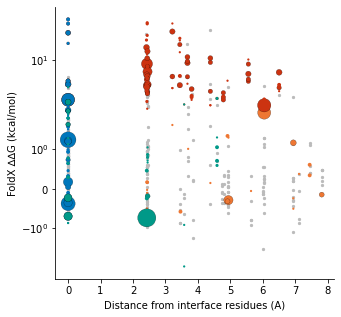

In [41]:
plot_scatter_two_scores(s_interface3D_notch1, s_fold_all_notch1, 
                        sections_for_colours=[s_fold_all_notch1, s_interface3D_notch1, s_ca_all_notch1], 
                        score_regions_for_colours=[[2, 100], [-1, 0.1], [0.9,1.1]],
                        score_region_colours=[foldx_observed_colour, interface_observed_colour, 
                                              calcium_observed_colour],
                        unobserved_mutation_colour=unobserved_colour, 
                        missense_mutation_colour=observed_colour,
                        plot_yscale='symlog', show_legend=False, figsize=(5, 5), unmutated_marker_size=5,
                        base_marker_size=5)
hide_top_and_right_axes()

## Proportion in three categories together

Check the expected and observed proportions of mutations in three selected categories. 

In [42]:
# Define the lookup to check if a mutations is in any of the categories
destabilising_or_interface_or_calcium_lookup = ORLookup(
    lookups=[fold, interface_lookup, ca_lookup],  # Use the FoldX, interface and calcium lookups.  
    thresholds=[2, 0.5, 0.5],  # Again pick a threshold of 2kcal/mol for the FoldX result, interface and calcium results are either 0 or 1 so set threshold at 0.5. 
    directions=[1, 1, 1],  # Want to exclude mutations with scores greater than the thresholds, so directions are all 1.
)

In [43]:
s = d_skin.run_section(notch1_section_definition_egf11_12, lookup=destabilising_or_interface_or_calcium_lookup, 
                    statistics=BinomTest())
# Proportion of mutations expected to occur in one of the three categories (not adjusting for spectrum)
print(len(s.null_mutations[s.null_mutations['score'] == 1])/len(s.null_mutations))
# Proportion of mutations expected to occur in one of the three categories (adjusting for spectrum)
res = s.get_results_dictionary()
print(res['binom_glob_k3_expected_proportion'])
print(res['binom_glob_k3_observed_proportion'])

0.7029126213592233
0.6612711421911491
0.8906077348066298
